In [2]:
from __future__ import division
import time
from time import gmtime, strftime

#import random
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib.colors as colors

import torch 
from torch.autograd import Variable
from torch import autograd, optim, nn

from sklearn.neighbors import NearestNeighbors

import numpy as np
import matplotlib.pyplot as plt

import gym
import agt_utils as au

%matplotlib inline 

In [3]:
from gym.envs.registration import register
register(
    id='FrozenLakeNotSlippery-v0',
    entry_point='gym.envs.toy_text:FrozenLakeEnv',
    kwargs={'map_name' : '4x4', 'is_slippery': False},
    max_episode_steps=100,
    reward_threshold=0.78, # optimum = .8196
)

gym_game = 'FrozenLakeNotSlippery-v0'

env = gym.make(gym_game)


In [5]:
#=====================
# Training Parameters
#=====================
#trial parameters
NUM_TRIALS = 30000
NUM_EVENTS = 50

discount_factor = 0.98

#agent parameters
if type(env.observation_space) == gym.spaces.box.Box:
    print "hello"
    in_dims = env.observation_space.shape[0]
else:
    print env.observation_space.n
    in_dims  = env.observation_space.n

dims = [in_dims,env.action_space.n]
model = au.AC_Net(dims)

#learning parameters
eta = 6e-3 #gradient descent learning rate
opt = au.optim.Adam(model.parameters(), lr = eta)

16


In [6]:
#EC__ = eu.ep_mem(model,100)

def tchecker(timez):
    global t_check_counter
    t_check_counter +=1 
    print(t_check_counter,"%.7f" %(time.time()-timez))
    return time.time()

def make_onehot(action):
    onehot = np.zeros(env.observation_space.n)
    onehot[action] = 1
    return onehot


In [7]:
#==================================
# Set up Data Recording Structures
#==================================
print_freq = 1./10
total_reward = [] #track total reward achieved in trial 
total_loss = [[],[]] #[actor loss, critic loss]

track_event = []

# record current time before beginning of trial
print "Run started: ", strftime("%a, %d %b %Y %H:%M:%S +0000", time.localtime())
runtime= time.time()
blocktime = time.time()

t_check_counter = 0
t_check = time.time()
timestamp = 1

#EC__.reset_cache()
env._max_episode_steps = NUM_EVENTS
#==================================
# Run Trial
#==================================
for trial in xrange(NUM_TRIALS):
    trial_start = time.time()
    
    init_state = env.reset()
    state = Variable(torch.FloatTensor([make_onehot(init_state)]))
    
    reward_sum = 0
    v_last = 0
    
    for event in xrange(NUM_EVENTS):
        choice, policy, value = au.select_action(model,state)
        choice_prob = policy[choice]
        
        if event < NUM_EVENTS: 
            next_state, reward, done, info = env.step(choice)
        
        model.rewards.append(reward)
        
        # update state
        state = Variable(torch.FloatTensor([make_onehot(next_state)]))

        delta = reward - value - v_last
        ### is it supposed to be current state?? 
        #EC__.add_mem(tuple(next_state[0]), choice, delta, timestamp)
        reward_sum += reward
        v_last = value
        timestamp += 1
        
        
        if done: 
            track_event.append(event)
            env.reset()
            break
    #track_event.append(event)    
    #value_map = au.generate_values(maze, model)
    p_loss, v_loss = au.finish_trial(model, discount_factor,opt)
    total_loss[0].append(p_loss.data[0])
    total_loss[1].append(v_loss.data[0])
    total_reward.append(reward_sum)
    #val_maps.append(value_map.copy())
    
    # print reward measure
    if trial%(print_freq*NUM_TRIALS)==0 or trial == NUM_TRIALS-1: 
        print "Trial {0} finished w total reward = {1} (Avg {2:.3f})".format(trial, reward_sum, float(reward_sum)/float(NUM_EVENTS)), "Block took {0:.3f}".format(time.time()-blocktime)
        blocktime = time.time() 
    
print "Run took {0:.3f}".format(time.time()-runtime)


Run started:  Mon, 19 Mar 2018 12:14:48 +0000

SFFF
FHFH
FFFH
HFFG
Trial 0 finished w total reward = 0.0 (Avg 0.000) Block took 0.005
Trial 3000 finished w total reward = 1.0 (Avg 0.020) Block took 5.502
Trial 6000 finished w total reward = 1.0 (Avg 0.020) Block took 4.784
Trial 9000 finished w total reward = 1.0 (Avg 0.020) Block took 5.235
Trial 12000 finished w total reward = 1.0 (Avg 0.020) Block took 5.120
Trial 15000 finished w total reward = 1.0 (Avg 0.020) Block took 4.828
Trial 18000 finished w total reward = 1.0 (Avg 0.020) Block took 4.841
Trial 21000 finished w total reward = 1.0 (Avg 0.020) Block took 4.440
Trial 24000 finished w total reward = 1.0 (Avg 0.020) Block took 4.478
Trial 27000 finished w total reward = 1.0 (Avg 0.020) Block took 4.768
Trial 29999 finished w total reward = 1.0 (Avg 0.020) Block took 4.690
Run took 48.692


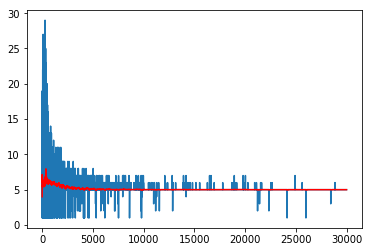

In [10]:
plt.figure(0)
plt.plot(track_event)
plt.plot(eu.running_mean(track_event,100), 'r')

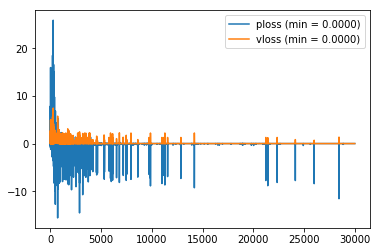

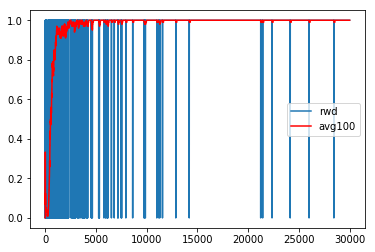

In [9]:
plt.figure(0)
plt.plot(total_loss[0], label='ploss (min = {0:.4f})'.format(min(np.abs(total_loss[0]))))
plt.plot(total_loss[1], label='vloss (min = {0:.4f})'.format(min(np.abs(total_loss[1]))))
plt.legend(loc=0)

import env_utils as eu
plt.figure(1)

plt.plot(total_reward, label='rwd')
plt.plot(eu.running_mean(total_reward, 100), 'r', label='avg100')
plt.legend(loc=0)
plt.show()